### VAE


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
%cd drive/MyDrive/Deep_learning/

[Errno 2] No such file or directory: 'drive/MyDrive/Deep_learning/'
/content/drive/MyDrive/Deep_learning


In [17]:
!git init

Reinitialized existing Git repository in /content/drive/MyDrive/Deep_learning/.git/


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

In [19]:
train_data_path = "/content/drive/MyDrive/Deep_learning/Proyecto 1 - DAE + VAE/processed_dataset/train/*/*.npy"
val_data_path   = "/content/drive/MyDrive/Deep_learning/Proyecto 1 - DAE + VAE/processed_dataset/val/*/*.npy"
test_data_path  = "/content/drive/MyDrive/Deep_learning/Proyecto 1 - DAE + VAE/processed_dataset/test/*/*.npy"

In [20]:
# Función para cargar una imagen .npy (ya preprocesada y normalizada)
def load_image(file_path):
    file_path = file_path.numpy().decode("utf-8")
    image = np.load(file_path).astype(np.float32)
    return image

# Función para mapear el dataset
def load_and_preprocess(file_path):
    image = tf.py_function(func=load_image, inp=[file_path], Tout=tf.float32)
    image.set_shape([256, 256, 3])
    return image

In [21]:

# Crear datasets a partir de las rutas de archivos
train_file_paths = glob.glob(train_data_path, recursive=True)
val_file_paths   = glob.glob(val_data_path, recursive=True)
test_file_paths  = glob.glob(test_data_path, recursive=True)

print("Total imágenes (train):", len(train_file_paths))
print("Total imágenes (val):", len(val_file_paths))
print("Total imágenes (test):", len(test_file_paths))

Total imágenes (train): 138
Total imágenes (val): 30
Total imágenes (test): 30


In [22]:
# Convertir las rutas en tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_file_paths)
val_dataset   = tf.data.Dataset.from_tensor_slices(val_file_paths)
test_dataset  = tf.data.Dataset.from_tensor_slices(test_file_paths)

In [23]:
# Mapear la función de carga para obtener la imagen limpia
train_dataset = train_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset   = val_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset  = test_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
# Definir el tamaño de batch y optimizar la carga
batch_size = 16
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset   = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Visualizar algunos ejemplos para confirmar la carga
clean_batch = next(iter(train_dataset))
print("Shape de un batch del dataset VAE:", clean_batch.shape)


Shape de un batch del dataset VAE: (16, 256, 256, 3)


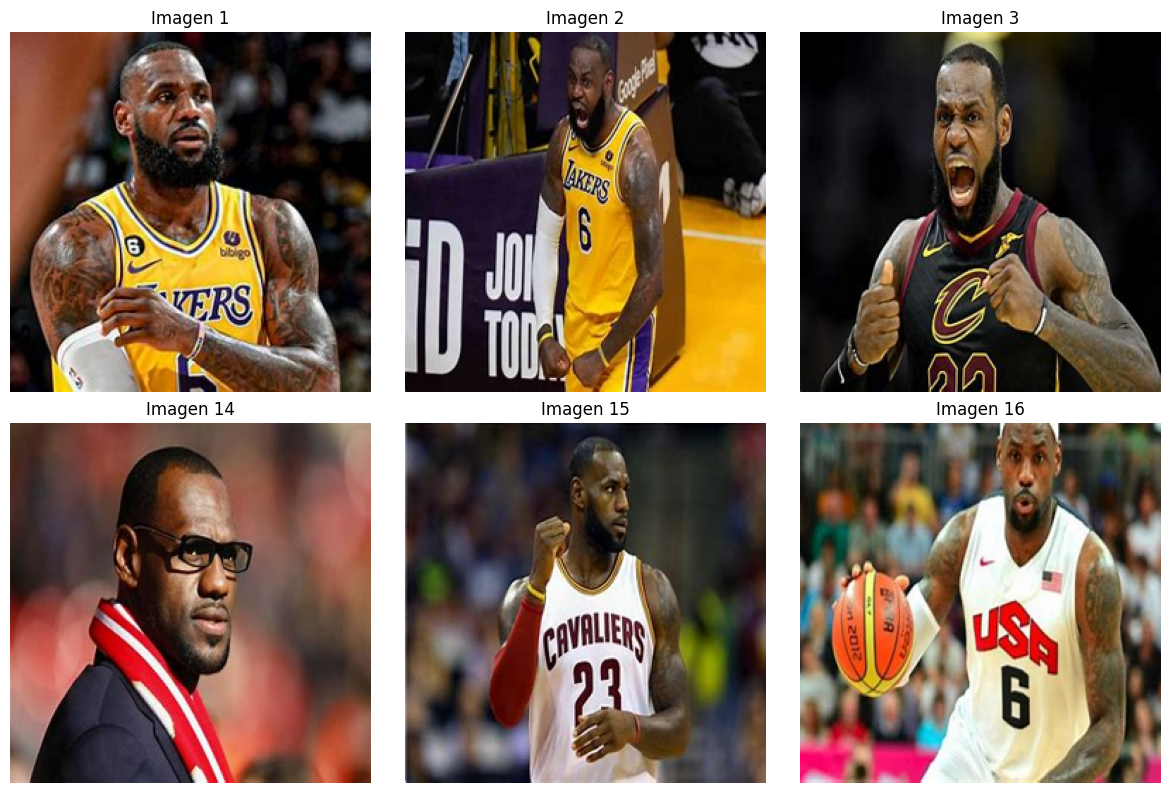

In [25]:
plt.figure(figsize=(12, 8))

# Mostrar las primeras 3 imágenes (fila superior)
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(clean_batch[i].numpy())
    plt.title(f"Imagen {i+1}")
    plt.axis("off")

# Mostrar las últimas 3 imágenes (fila inferior)
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(clean_batch[-3 + i].numpy())
    plt.title(f"Imagen {clean_batch.shape[0]-3+i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


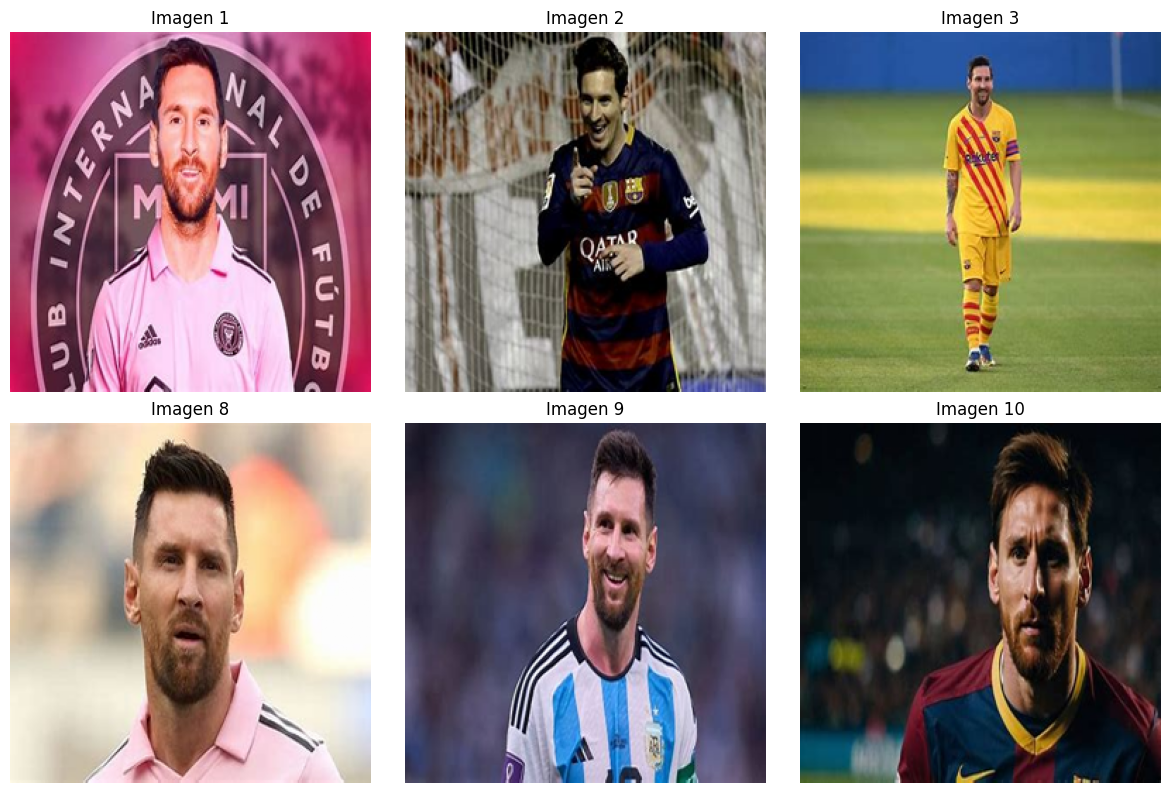

In [26]:
# Iterar por todo el dataset para obtener el último batch
last_batch = None
for batch in train_dataset:
    last_batch = batch

# last_batch contiene ahora las imágenes del último batch
plt.figure(figsize=(12, 8))

# Mostrar las primeras 3 imágenes del último batch (fila superior)
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(last_batch[i].numpy())
    plt.title(f"Imagen {i+1}")
    plt.axis("off")

# Mostrar las últimas 3 imágenes del último batch (fila inferior)
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(last_batch[-3 + i].numpy())
    plt.title(f"Imagen {last_batch.shape[0]-3+i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Bien, ya tenemos nuestro dataset listo para continuar con la construcción del VAE.

La red recibe  imágenes de tamaño (256,256,3) y que, a través de varias capas convolucionales y de pooling, genere dos vectores:

+ z_mean: Es un vector que representa el "centro" de la distribución en el espacio latente. Cada componente de este vector nos dice, en cierta dimensión, cuál es el valor medio que se espera para esa imagen.

+ z_log_var: Es un vector que representa el logaritmo de la varianza de la distribución latente en cada dimensión. La varianza nos dice qué tan dispersos están los datos alrededor de la media, es decir, la "anchura" de la distribución.

Este encoder nos permitirá aprender una representación comprimida de las imágenes.

In [27]:
latent_dim = 64

# Entrada del encoder: imagen de tamaño 256x256 con 3 canales (RGB)
encoder_inputs = keras.Input(shape=(256, 256, 3), name="encoder_input")

# Primer bloque convolucional
x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D(2, padding="same")(x)  # Reduce el tamaño a la mitad

# Segundo bloque convolucional
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)

# Tercer bloque convolucional
x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)

# Guardar la forma antes de aplanar (esto será útil para el decoder)
shape_before_flattening = tf.keras.backend.int_shape(x)[1:]
print("Forma antes de flattening:", shape_before_flattening)

# Aplanar la salida para obtener un vector
x = layers.Flatten()(x)

# Dos capas densas para obtener la media y el logaritmo de la varianza del espacio latente
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Puedes visualizar las formas resultantes:
print("Dimensión de z_mean:", z_mean.shape)
print("Dimensión de z_log_var:", z_log_var.shape)

Forma antes de flattening: (32, 32, 128)
Dimensión de z_mean: (None, 64)
Dimensión de z_log_var: (None, 64)


Ahora vamos a pasar con la función de sampling. Esto nos permite muestrar un vector latente $z$ a partir de los parámetros *z_mean* y *z_log_var* que es lo que acabamos de calcular.

In [28]:
# Función de reparameterización (sampling)
def sampling(args):
    """
    Recibe como entrada (z_mean, z_log_var) y devuelve un vector z muestreado.
    """
    z_mean, z_log_var = args
    # Extraemos epsilon de una distribución normal estándar
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    # Calculamos z: se muestrea a partir de z_mean y z_log_var
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
    return z

# Capa Lambda para aplicar la función de reparameterización en el modelo
z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

# Verificamos la forma de z
print("Dimensión de z (muestra latente):", z.shape)


Dimensión de z (muestra latente): (None, 64)


### ¿Por qué utilizamos la reparameterización?

+ Nuestro encoder no solo nos da un valor fijo para representar una imagen, sino que nos dice: "esta imagen se parece a una distribución normal con un centro (z_mean) y una dispersión (z_log_var)". Ahora, queremos obetener un valor de esa distribución para usarlo en el decoder y reconstruir la imagen.

+ El tema con esto se que en el poceso de muestro no se puede calcular cómo cambiar los parámetros para mejorar la reconstrucción de la imagen, porque la operación del muestreo introduce ruido aleatorio que impide pasar el gradiente.

### Decoder

In [29]:
# Definir la entrada del decoder: vector latente de dimensión (latent_dim,)
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")

# Expandir el vector latente a la dimensión necesaria para reestructurar
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(latent_inputs)
# Reestructuramos a la forma (32, 32, 128)
x = layers.Reshape(shape_before_flattening)(x)

# Ahora aplicamos capas de deconvolución y upsampling para reconstruir la imagen
x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)  # Aumenta la altura y anchura

x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)

x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)

# Capa final para reconstruir la imagen de 256x256x3 con activación sigmoid
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same", name="decoder_output")(x)

# Construir el modelo decoder
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 131072)              │       8,519,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2DTranspose)     │ (None, 256, 256, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,760,387 (33.42 MB)

 Trainable params: 8,760,387 (33.42 MB)

 Non-trainable params: 0 (0.00 B)

Ahora vamos a conectar el encoder con el decoder.

In [30]:
# Conectar encoder y decoder para obtener la reconstrucción
vae_outputs = decoder(z)

# Construir el modelo VAE completo: desde la entrada del encoder hasta la salida del decoder
vae = keras.Model(encoder_inputs, vae_outputs, name="vae")

# Definir la pérdida de reconstrucción (MSE entre imagen original y reconstruida)
# Aplanamos las imágenes para calcular la pérdida sobre todos los píxeles
reconstruction_loss = tf.reduce_mean(
    keras.losses.mse(tf.keras.backend.flatten(encoder_inputs), tf.keras.backend.flatten(vae_outputs))
)
# Escalar la pérdida (opcional, aquí se multiplica por el número total de píxeles)
reconstruction_loss *= 256 * 256 * 3

# Definir la pérdida de divergencia KL
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss *= -0.5

# Pérdida total del VAE: suma de la pérdida de reconstrucción y la divergencia KL
vae_loss = reconstruction_loss + kl_loss

# Compilar el modelo con optimizador Adam
vae.compile(optimizer="adam")

# Mostrar el resumen del modelo VAE
vae.summary()


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
